In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
from tensorflow import keras
from tensorflow.keras.layers import LSTM, RepeatVector
from tensorflow.keras.optimizers import Adam, SGD

2023-03-13 18:07:11.834934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4 Physical GPUs, 1 Logical GPU


2023-03-13 18:07:13.337318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-13 18:07:13.338641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-13 18:07:13.340171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-13 18:07:13.341734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-13 18:07:13.345671: I tensorflow/compiler/xla/stream_executo

In [3]:
import geopandas as gp
import movingpandas as mpd
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
from shapely.geometry import Point
from joblib import Parallel, delayed

In [4]:
import sys
sys.path.append('..')
import attack
gdf = gp.read_file('../data/freemove/raw_full.geojson', crs='EPSG:4326')
true_mapping = gdf[['TRIP_ID', 'PERSON_ID']].sort_values('TRIP_ID').drop_duplicates().reset_index(drop=True)

In [8]:
# create geojson of points
rows = []
for i, row in tqdm(gdf.iterrows(), total=len(gdf), miniters=10):
    person_id = row.PERSON_ID
    trip_id = row.TRIP_ID
    leg_id = row.LEG_ID
    leg_start = datetime.strptime(str(row.LEG_START), '%Y-%m-%dT%H:%M:%S')
    leg_end = datetime.strptime(str(row.LEG_END), '%Y-%m-%dT%H:%M:%S')
    trip_purpose_ids = row.TRIP_PURPOSE_IDS
    traffic_mode = row.TRAFFIC_MODE
    leg_len_in_mtrs = row.LEG_LEN_IN_MTRS
    leg_duration_in_secs = row.LEG_DURATION_IN_SECS

    # interpolate time of points of a leg since we only have start and end time
    total_points_of_leg = len(row.geometry.coords)
    interpolattion_increment = leg_duration_in_secs / total_points_of_leg

    for point_i, point in enumerate(row.geometry.coords):
        new_row = {"PERSON_ID": person_id, 
                   "TRIP_ID": trip_id, 
                   "LEG_ID": leg_id, 
                   "LEG_START": leg_start, 
                   "LEG_END": leg_end,
                   "TIME": leg_start + timedelta(seconds=round(interpolattion_increment * point_i, ndigits=0)),
                   "TRIP_PURPOSE_IDS": trip_purpose_ids, 
                   "TRAFFIC_MODE": traffic_mode, 
                   "LEG_LEN_IN_MTRS": leg_len_in_mtrs, 
                   "LEG_DURATION_IN_SECS": leg_duration_in_secs, 
                   "LAT": Point(point).y,
                   "LON": Point(point).x}
        rows.append(new_row)


freemove_raw_point_gdf = pd.DataFrame(rows)[["PERSON_ID", "TRIP_ID", "TIME", "LAT", "LON"]]
freemove_raw_point_gdf

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4958/4958 [00:42<00:00, 116.14it/s]


,PERSON_ID,TRIP_ID,TIME,LAT,LON
0,16348,985222,2022-10-31 09:15:57,52.454451,13.504967
1,16348,985222,2022-10-31 09:15:58,52.454463,13.504983
2,16348,985222,2022-10-31 09:15:59,52.454454,13.505009
3,16348,985222,2022-10-31 09:16:00,52.454422,13.505042
4,16348,985222,2022-10-31 09:16:01,52.454391,13.505098
...,...,...,...,...,...
1637556,17273,1012443,2022-11-15 10:00:46,52.501937,13.355693
1637557,17273,1012443,2022-11-15 10:00:47,52.501903,13.355708
1637558,17273,1012443,2022-11-15 10:00:48,52.501874,13.355723
1637559,17273,1012443,2022-11-15 10:00:49,52.501847,13.355738


<Axes: >

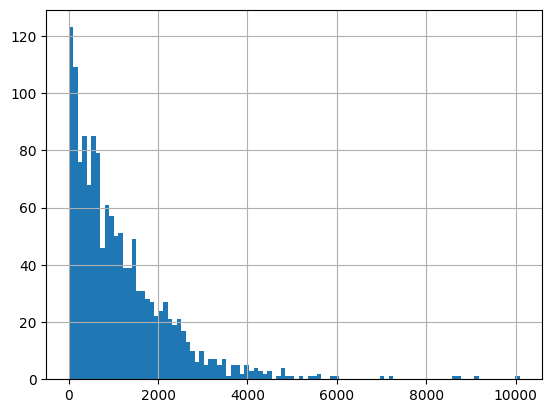

In [9]:
# plot the distribution of the number of points per trajectory
freemove_raw_point_gdf.groupby('TRIP_ID').size().hist(bins=100)


In [10]:
freemove_point_collection = mpd.TrajectoryCollection(freemove_raw_point_gdf, traj_id_col='TRIP_ID', obj_id_col ='PERSON_ID', t='TIME', x='LON', y='LAT', crs='epsg:4326')

In [11]:
detector = mpd.TrajectoryStopDetector(freemove_point_collection)

In [12]:
start_locations = freemove_point_collection.get_start_locations().reset_index(names=['TIME'])[['TRIP_ID', 'PERSON_ID', 'TIME', 'geometry']]
end_locations = freemove_point_collection.get_end_locations().reset_index(names=['TIME'])[['TRIP_ID', 'PERSON_ID', 'TIME', 'geometry']]

/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/

/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/

/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/

/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/

/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/

/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/

/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/

/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/

/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/

/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/

/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/

/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/

/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/trajectory_collection.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(x)
/usr/local/lib/python3.8/dist-packages/movingpandas/

In [13]:
stop_points = detector.get_stop_points(min_duration=timedelta(seconds=60), max_diameter=200).reset_index()

In [14]:
# assign middle time between start and end time of a stop to stop point
stop_points['time'] = stop_points.apply(lambda x: timedelta(seconds=round((x.end_time - x.start_time).total_seconds()/2)) + x.start_time, axis=1)

In [15]:
# Rename columns to match with start and end points
stop_points = stop_points.rename(columns={'traj_id': 'TRIP_ID', 'time': 'TIME'})

In [16]:
# Merge PERSON_ID to stop points from start location df
stop_points = pd.merge(stop_points[['TRIP_ID', 'TIME', 'geometry']], start_locations[['TRIP_ID', 'PERSON_ID']], on='TRIP_ID', how='left')

In [17]:
points = pd.concat([start_locations, stop_points, end_locations]).sort_values(['TRIP_ID', 'TIME']).reset_index(drop=True)

points

,TRIP_ID,PERSON_ID,TIME,geometry
0,978933,17246,2022-10-21 14:59:24,POINT (13.31753 52.53094)
1,978933,17246,2022-10-21 15:02:10,POINT (13.32791 52.53281)
2,978933,17246,2022-10-21 15:10:39,POINT (13.36288 52.53582)
3,978933,17246,2022-10-21 15:13:28,POINT (13.36931 52.52905)
4,978933,17246,2022-10-21 15:16:03,POINT (13.36997 52.52837)
...,...,...,...,...
12346,1015191,16370,2022-11-17 22:09:33,POINT (13.36541 52.47671)
12347,1015191,16370,2022-11-17 22:15:28,POINT (13.35614 52.46070)
12348,1015191,16370,2022-11-17 22:17:07,POINT (13.35593 52.45973)
12349,1015191,16370,2022-11-17 22:19:27,POINT (13.35338 52.44808)


<Axes: >

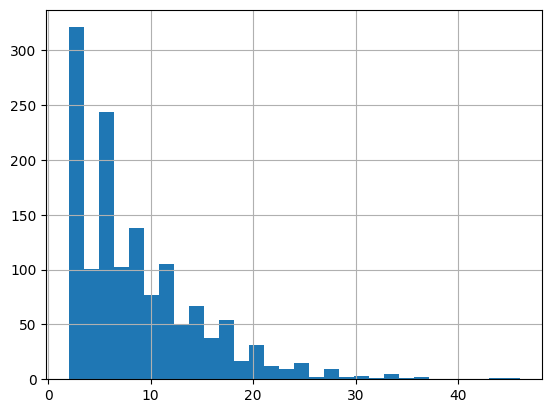

In [18]:
points.groupby('TRIP_ID').size().hist(bins=30)

In [78]:
# normalize a list of integers and round to 2 decimals
def normalize_list(l):
    return [round(x / max(l), 2) for x in l]

def get_random_context(lat, lon):
    lat = lat
    lon = lon
    return normalize_list([np.random.randint(0, 500) for i in range(20)])
    

In [24]:
import targomo_api
from tqdm import tqdm
tqdm.pandas()
        

# points['geographical_context'] = points.progress_apply(lambda x: targomo_api.get_geographical_context_vector(x.lat, x.lon), axis=1)
points['geographical_context'] = Parallel(n_jobs=-4, verbose=5)(delayed(targomo_api.get_geographical_context_vector)(p.geometry.y, p.geometry.x) for i, p in points.iterrows()) 
# save to pickle
points.to_pickle('../data/freemove/freemove_point_geographical_context.pickle')

[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done  38 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-4)]: Done 398 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-4)]: Done 632 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-4)]: Done 902 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-4)]: Done 1208 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-4)]: Done 1550 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-4)]: Done 1928 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-4)]: Done 2342 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-4)]: Done 2792 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-4)]: Done 3278 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-4)]: Done 3800 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-4)]: Done 4358 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-4)]: Done 4952 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-4)]: Done 5582 tasks      |

In [25]:
points = pd.read_pickle('../data/freemove/freemove_point_geographical_context.pickle')

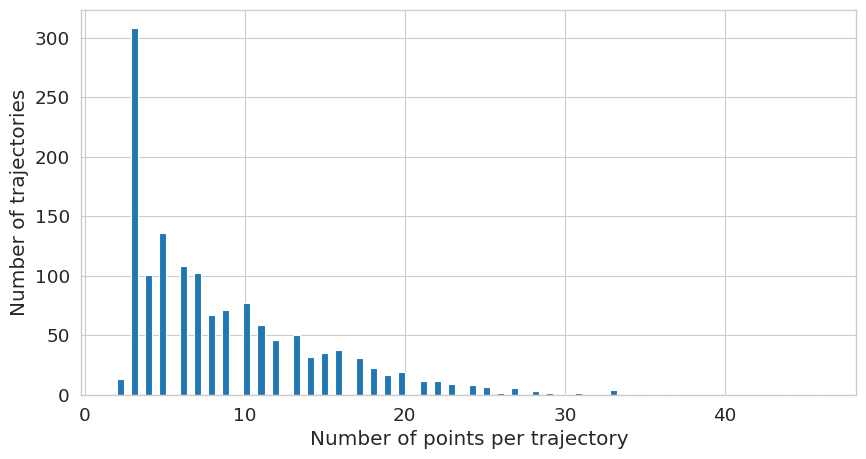

In [6]:
# plot distribution of number of points per trajectory
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(10, 5))
plt.hist(points.groupby('TRIP_ID').count()['PERSON_ID'], bins=100)
plt.xlabel('Number of points per trajectory')
plt.ylabel('Number of trajectories')
plt.show()

In [7]:
max_points = points.groupby('TRIP_ID').count()['PERSON_ID'].max()
geographical_context_dim = len(points['geographical_context'].iloc[0])


X = np.empty(shape=[points.TRIP_ID.nunique(), max_points, geographical_context_dim])
Y = np.empty(shape=[points.TRIP_ID.nunique(),])

In [8]:
# convert points into numpy array for each trajectory
for index, traj in enumerate(points.groupby('TRIP_ID')):    
    # get the trajectory id
    traj_id = traj[0]

    # get the user id
    user_id = traj[1]['PERSON_ID'].iloc[0]

    Y[index] = user_id

    for idx, point in traj[1].reset_index(drop=True).iterrows():
        X[index, idx, :] = point['geographical_context']

In [10]:
timesteps = 46
input_dim = 10
latent_dim = 100

inputs = keras.Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim, return_sequences=True)(inputs)
encoded = LSTM(latent_dim)(encoded)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(latent_dim, return_sequences=True)(decoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = keras.Model(inputs, decoded)
encoder = keras.Model(inputs, encoded)

opt = Adam(learning_rate=0.001)

sequence_autoencoder.compile(optimizer='adam', loss='mae')

sequence_autoencoder.fit(X, X,
                epochs=3000,
                batch_size=256,
                shuffle=True)

Epoch 1/3000
6/6 [==============================] - 4s 22ms/step - loss: nan
Epoch 2/3000
6/6 [==============================] - 0s 21ms/step - loss: nan
Epoch 3/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 4/3000
6/6 [==============================] - 0s 21ms/step - loss: nan
Epoch 5/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 6/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 7/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 8/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 9/3000
6/6 [==============================] - 0s 21ms/step - loss: nan
Epoch 10/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 11/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 12/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 13/3000
6/6 [==============================] - 0s 22ms/step - loss:

6/6 [==============================] - 0s 17ms/step - loss: nan
Epoch 107/3000
6/6 [==============================] - 0s 15ms/step - loss: nan
Epoch 108/3000
6/6 [==============================] - 0s 15ms/step - loss: nan
Epoch 109/3000
6/6 [==============================] - 0s 18ms/step - loss: nan
Epoch 110/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 111/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 112/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 113/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 114/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 115/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 116/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 117/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 118/3000
6/6 [==============================] - 0s 22ms/step 

6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 313/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 314/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 315/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 316/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 317/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 318/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 319/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 320/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 321/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 322/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 323/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 324/3000
6/6 [==============================] - 0s 22ms/step 

6/6 [==============================] - 0s 21ms/step - loss: nan
Epoch 519/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 520/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 521/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 522/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 523/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 524/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 525/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 526/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 527/3000
6/6 [==============================] - 0s 21ms/step - loss: nan
Epoch 528/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 529/3000
6/6 [==============================] - 0s 22ms/step - loss: nan
Epoch 530/3000
6/6 [==============================] - 0s 22ms/step 

KeyboardInterrupt: 

In [134]:
from keras.layers import Dense, LSTM, RepeatVector, GRU, Bidirectional, InputSpec
import keras.backend as K


class ClusteringLayer(keras.layers.Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [116]:
# Initialize Clustering Layer KMEANS
from sklearn.cluster import KMeans, DBSCAN

N_CLUSTERS = 74

# Build clustering model
clustering_layer = ClusteringLayer(N_CLUSTERS, name='clustering')(encoder.output)
model = keras.Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer=opt, loss='kld')

# Initialize cluster centers using k-means.
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(X))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

# Get labels (ground truth)
y = attack.getGroundTruth(true_mapping)



44/44 [==============================] - 1s 4ms/step


In [22]:
# Evaluate base line hdbscan
y = attack.getGroundTruth(true_mapping)
import hdbscan
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN

h_dbscan = hdbscan.HDBSCAN()
h_dbscan.fit(encoder.predict(X))

kmeans_cl


acc = np.round(attack.cluster_acc(y, h_dbscan.labels_), 5)
nmi = np.round(metrics.normalized_mutual_info_score(y, h_dbscan.labels_), 5)
ari = np.round(metrics.adjusted_rand_score(y, h_dbscan.labels_), 5)

attack.evaluate(h_dbscan.labels_, true_mapping)

44/44 [==============================] - 0s 3ms/step
Homogeneity: 0.136
Completeness: 0.388
V-measure: 0.201
Rand index: 0.509
ARI: 0.001
MI: 0.536
NMI: 0.201
AMI: 0.091
Cluster accuracy: 0.116
0.11648 0.20122 0.00077


In [166]:
x, y = datasets.load_iris(return_X_y=True)

# TODO implement your own oracle that will, for example, query a domain expert via GUI or CLI
oracle = ExampleOracle(y, max_queries_cnt=10)

active_learner = MinMax(n_clusters=3)
active_learner.fit(x, oracle=oracle)
pairwise_constraints = active_learner.pairwise_constraints_

In [12]:
import numpy as np

# Get unique values of PERSON_ID column
unique_person_id = np.unique(true_mapping['PERSON_ID'])

# Initialize matrix with all zeros
link_matrix = np.zeros((len(true_mapping), len(true_mapping)))

# Randomly select 10 unique PERSON_ID values
selected_person_id = np.random.choice(unique_person_id, 200, replace=True)

# Loop through selected PERSON_ID values
for person_id in selected_person_id:
    # Get indices of rows with same PERSON_ID value
    idx_same = np.where(true_mapping['PERSON_ID'] == person_id)[0]
    # Get indices of rows with different PERSON_ID value
    idx_diff = np.where(true_mapping['PERSON_ID'] != person_id)[0]
    # Randomly select 1 must link pair
    must_link_pair = (np.random.choice(idx_same), np.random.choice(idx_same))
    # Randomly select 1 cannot link pair
    cannot_link_pair = (np.random.choice(idx_same), np.random.choice(idx_diff))
    # Update link matrix with must link pair and cannot link pair
    link_matrix[must_link_pair[0], must_link_pair[1]] = 1
    link_matrix[must_link_pair[1], must_link_pair[0]] = 1
    link_matrix[cannot_link_pair[0], cannot_link_pair[1]] = -1
    link_matrix[cannot_link_pair[1], cannot_link_pair[0]] = -1

# Print link matrix
print("Link matrix:")
print(link_matrix)


Link matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
from sklearn.cluster import KMeans
from constrainedclustering.utils.metrics import evalSplit
from constrainedclustering.utils.clustering import Clustering
from constrainedclustering.models.kernel_opt import kernel_clustering
from constrainedclustering.kernels.features import produce_kernels, normalize_and_check_kernels

# Define the different kernels we want to compute
kernels_name = ['rbf', 'sigmoid', 'polynomial', 
                'laplacian', 'linear']

# Define options on the kernels computation
kernel_args = {"normalize": "expectation", 
               "check_method": "trivial", 
               "clip": True}

train = encoder.predict(X)
# Compute and save kernels 
## As kernels computation is slow, the function saves it in a local folder
names, kernels = produce_kernels('freemove', kernels_name, train, n_jobs = -4)
names, kernels = normalize_and_check_kernels(names, kernels, 74, n_jobs = -4, **kernel_args)

Ran on 13 March 2023 09:36:39
Local
44/44 [==============================] - 0s 2ms/step


In [14]:
from scipy.sparse import coo_matrix
# Define the clustering algorithm to use
clustering = Clustering.create("kmeans", classes = 74, constraint_matrix = coo_matrix(link_matrix))

In [15]:
assignment = kernel_clustering(kernels, clustering, coo_matrix(link_matrix))

# Get labels (ground truth)
labels = attack.getGroundTruth(true_mapping)
performances["Without Approx"] = evalSplit(assignment, labels, train)['test']

TypeError: list indices must be integers or slices, not list

In [196]:
from sklearn import datasets, metrics
from active_semi_clustering.semi_supervised.pairwise_constraints import PCKMeans, COPKMeans, MPCKMeans, MPCKMeansMF
from active_semi_clustering.active.pairwise_constraints import ExampleOracle, ExploreConsolidate, MinMax

N_CLUSTERS = 74

# Get labels (ground truth)
y = np.asarray(attack.getGroundTruth(true_mapping))

clusterer = MPCKMeansMF(n_clusters=N_CLUSTERS)
clusterer.fit(encoder.predict(X), ml=pairwise_constraints[0], cl=pairwise_constraints[1])

metrics.adjusted_rand_score(y, clusterer.labels_)

44/44 [==============================] - 0s 3ms/step


EmptyClustersException: 

In [117]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [83]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(X.shape[0])

batch_size = 256

tol = 0.001 # tolerance threshold to stop training

In [86]:
from sklearn import metrics

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(X, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(attack.cluster_acc(y, y_pred), 5)
            nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
            ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, X.shape[0])]
    loss = model.train_on_batch(x=X[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= X.shape[0] else 0

Iter 0: acc = 0.15554, nmi = 0.38059, ari = 0.05077  ; loss= 0
Iter 140: acc = 0.14062, nmi = 0.35086, ari = 0.04053  ; loss= 0.50536
Iter 280: acc = 0.13778, nmi = 0.34690, ari = 0.04209  ; loss= 0.24695
Iter 420: acc = 0.14773, nmi = 0.35722, ari = 0.04648  ; loss= 0.22267
Iter 560: acc = 0.14915, nmi = 0.35896, ari = 0.04522  ; loss= 0.30277
Iter 700: acc = 0.15199, nmi = 0.35756, ari = 0.04716  ; loss= 0.30315
Iter 840: acc = 0.14347, nmi = 0.35211, ari = 0.04388  ; loss= 0.31114
Iter 980: acc = 0.14489, nmi = 0.35549, ari = 0.04571  ; loss= 0.3203
Iter 1120: acc = 0.14631, nmi = 0.35612, ari = 0.04666  ; loss= 0.31212
Iter 1260: acc = 0.15199, nmi = 0.35664, ari = 0.04818  ; loss= 0.33413
Iter 1400: acc = 0.14986, nmi = 0.35244, ari = 0.04497  ; loss= 0.33451
Iter 1540: acc = 0.15128, nmi = 0.35357, ari = 0.04714  ; loss= 0.32365
Iter 1680: acc = 0.14631, nmi = 0.34674, ari = 0.04184  ; loss= 0.35196
Iter 1820: acc = 0.14844, nmi = 0.34444, ari = 0.04098  ; loss= 0.34894
Iter 1960

In [118]:
# Train AE and clustering layer at the same time
model = keras.Model(inputs=inputs,
            outputs=[clustering_layer, sequence_autoencoder.output])
pretrain_optimizer = SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

In [119]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(X, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(attack.cluster_acc(y, y_pred), 5)
            nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
            ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, X.shape[0])]
    loss = model.train_on_batch(x=X[idx], y=[p[idx], X[idx]])
    index = index + 1 if (index + 1) * batch_size <= X.shape[0] else 0

Iter 0: acc = 0.15767, nmi = 0.38218, ari = 0.04953  ; loss= [0.04469 0.39319 0.00537]
Iter 140: acc = 0.15341, nmi = 0.37713, ari = 0.04714  ; loss= [0.02636 0.22488 0.00387]
Iter 280: acc = 0.14915, nmi = 0.37397, ari = 0.04631  ; loss= [0.0311  0.27474 0.00363]
Iter 420: acc = 0.15909, nmi = 0.37903, ari = 0.05222  ; loss= [0.03942 0.34276 0.00514]
Iter 560: acc = 0.15128, nmi = 0.37245, ari = 0.05090  ; loss= [0.03864 0.34609 0.00403]
Iter 700: acc = 0.15625, nmi = 0.36396, ari = 0.04975  ; loss= [0.05065 0.4673  0.00392]
Iter 840: acc = 0.15199, nmi = 0.35459, ari = 0.04491  ; loss= [0.04855 0.43113 0.00544]
Iter 980: acc = 0.15199, nmi = 0.35985, ari = 0.04885  ; loss= [0.06233 0.57656 0.00468]
Iter 1120: acc = 0.14560, nmi = 0.35484, ari = 0.04334  ; loss= [0.05323 0.48753 0.00448]
Iter 1260: acc = 0.14915, nmi = 0.35086, ari = 0.04691  ; loss= [0.08299 0.77169 0.00583]
Iter 1400: acc = 0.14560, nmi = 0.34775, ari = 0.04626  ; loss= [0.05332 0.48685 0.00464]
Iter 1540: acc = 0.1

KeyboardInterrupt: 

In [89]:
model.predict(X, verbose=0).shape

(1408, 74)

In [44]:
from sklearn.cluster import KMeans, DBSCAN
kmeans = KMeans(n_clusters=74, random_state=0, n_init="auto").fit(embedding)
# dbscan = DBSCAN(eps=0.5, min_samples=2).fit(X)

kmeans.labels_

array([52,  4, 10, ...,  7, 27, 73], dtype=int32)